In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from azure.cosmos import CosmosClient
import json
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
import pickle

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk prophet azure-cosmos


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
client = CosmosClient(url="https://msft-beta.documents.azure.com:443/", credential="yBg7spV75tDnpqDmkuFIJmVMB4ky3VzlcT8UCQagZeqvsx90v8cMH6WviJQQ3A0Z8FRn3poIzrYkACDbGAK1Nw==")

In [4]:
database = client.get_database_client("stock_trade_game")

container = database.get_container_client("STOCK")

stocks_history_raw = list(container.read_all_items())

In [5]:
json_string = json.dumps(stocks_history_raw[0])

df_raw = pd.read_json(json_string)

In [6]:
stocks_companies = ["IBM", "MSFT", "JPM", "TSLA", "META"]

df = {}
for index, row in df_raw.iterrows():
    for company_name in stocks_companies:
        data = row["Stock_Data_{}".format(company_name)]
        if company_name not in df:
          df[company_name] = {}
        df[company_name][data["date"]] = data["price"]

df = pd.DataFrame(df)
df.index = pd.DatetimeIndex(df.index)

In [7]:
df = df.reindex(pd.date_range('2015-08-26', '2023-08-04'), method='bfill').reset_index().rename(columns = { 'index': 'Date' })

In [8]:
pd.date_range('2015-08-26', '2023-08-04').difference(df["Date"])
 

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

21:26:42 - cmdstanpy - INFO - Chain [1] start processing
21:26:44 - cmdstanpy - INFO - Chain [1] done processing


Stock: MSFT
Mean Absolute Percentage Error (MAPE): 25.28%
Root Mean Squared Error (RMSE): 71.38
------------------------------------------


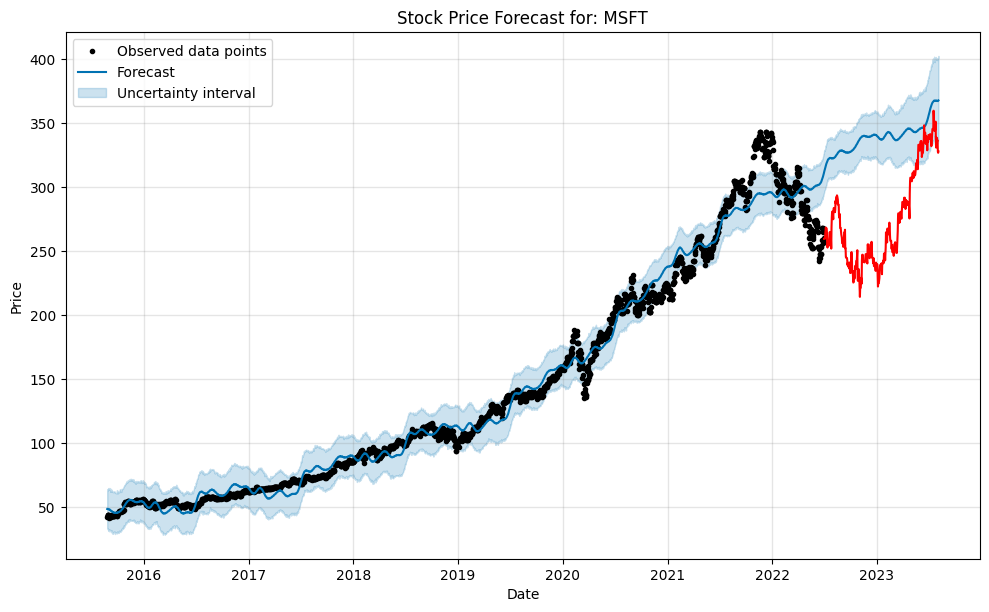

21:26:46 - cmdstanpy - INFO - Chain [1] start processing
21:26:47 - cmdstanpy - INFO - Chain [1] done processing


Stock: JPM
Mean Absolute Percentage Error (MAPE): 12.81%
Root Mean Squared Error (RMSE): 18.71
------------------------------------------


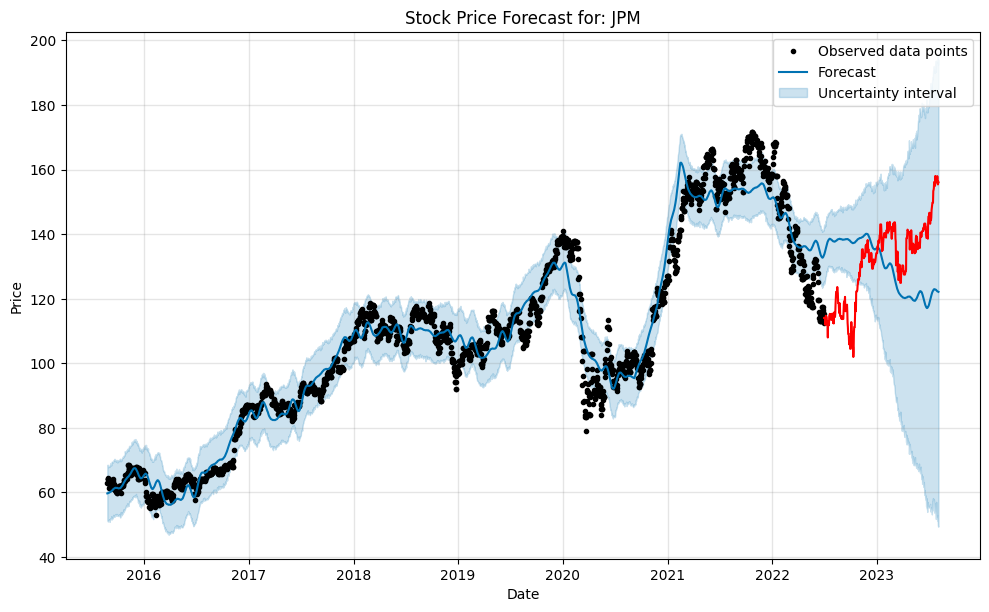

21:26:49 - cmdstanpy - INFO - Chain [1] start processing
21:26:49 - cmdstanpy - INFO - Chain [1] done processing


Stock: META
Mean Absolute Percentage Error (MAPE): 47.76%
Root Mean Squared Error (RMSE): 83.57
------------------------------------------


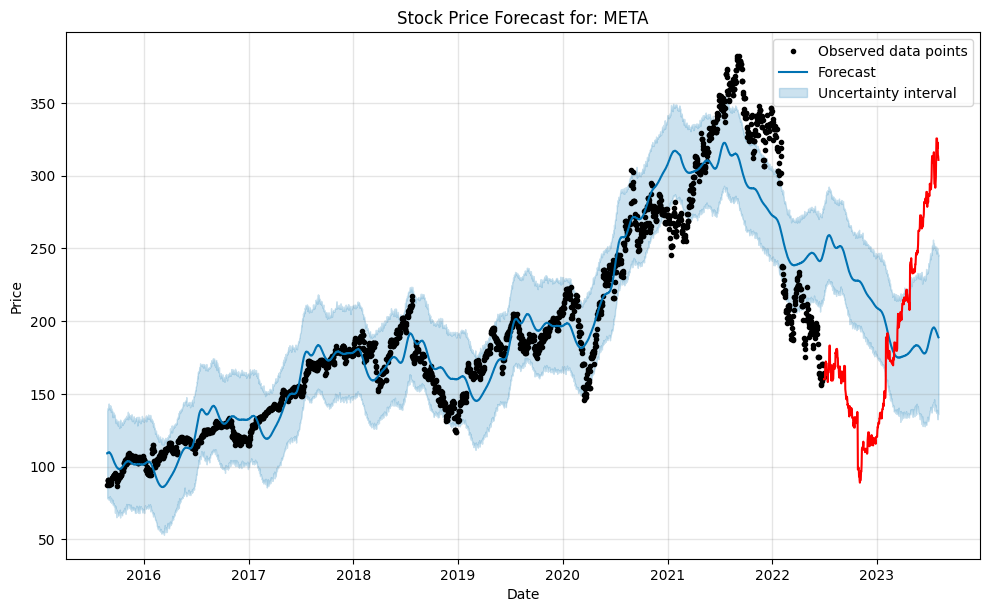

21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:51 - cmdstanpy - INFO - Chain [1] done processing


Stock: TSLA
Mean Absolute Percentage Error (MAPE): 392.63%
Root Mean Squared Error (RMSE): 811.17
------------------------------------------


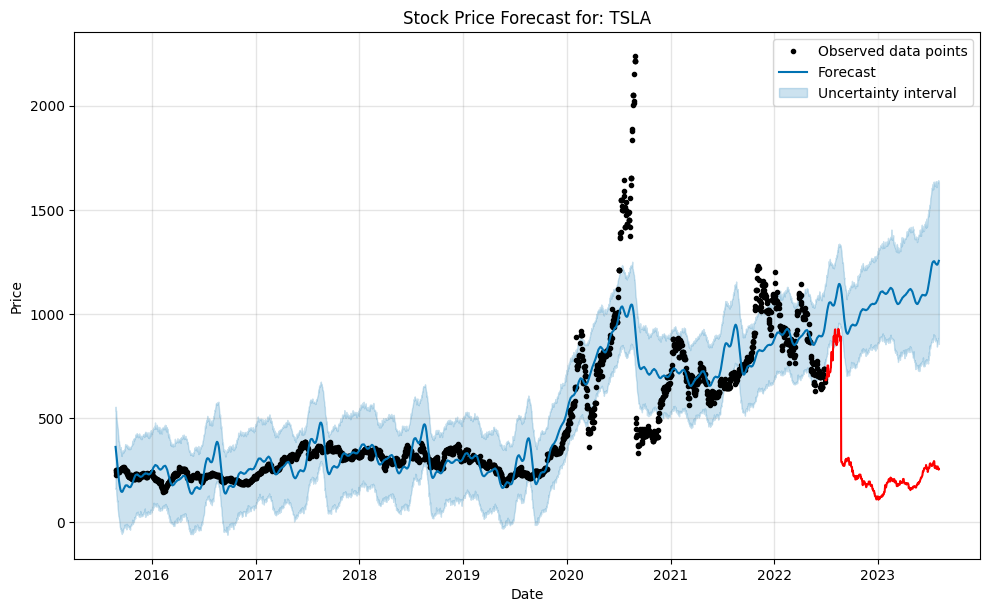

21:26:52 - cmdstanpy - INFO - Chain [1] start processing
21:26:53 - cmdstanpy - INFO - Chain [1] done processing


Stock: IBM
Mean Absolute Percentage Error (MAPE): 6.15%
Root Mean Squared Error (RMSE): 9.91
------------------------------------------


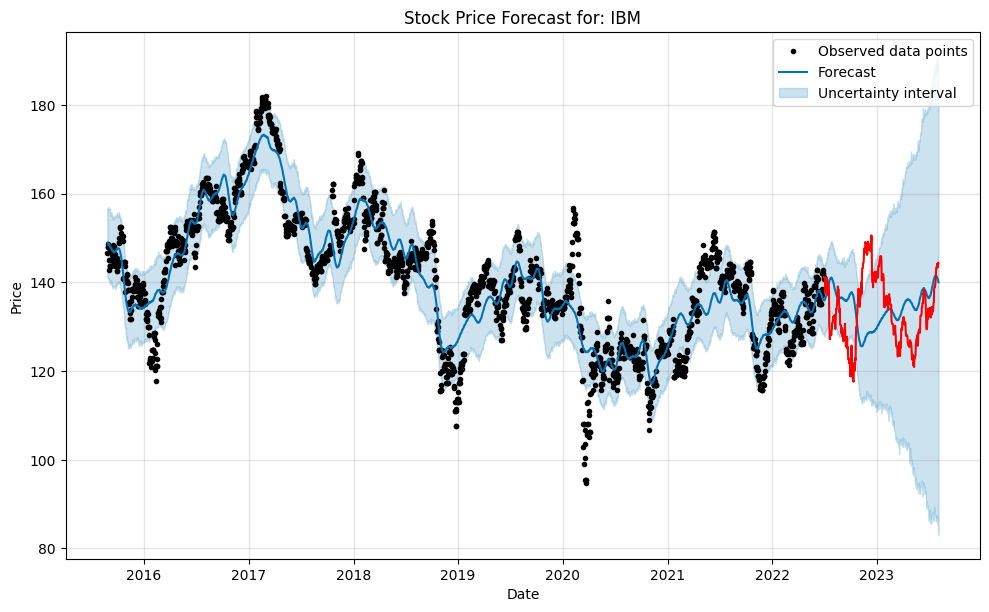

In [9]:

# Assuming you have imported all the required libraries and loaded the data frame as 'df'

for stock in ["MSFT", "JPM", "META", "TSLA", "IBM"]:
    data = {
        'ds': df["Date"],
        'y': pd.to_numeric(df[stock])
    }

    df_model_data = pd.DataFrame(data)

    df_model_data['ds'] = pd.to_datetime(df_model_data['ds'])
    model = Prophet()

    # Split data into training and testing sets
    train_data = df_model_data[:-400]  # Assuming the last 100 rows are for testing
    test_data = df_model_data[-400:]

    # Fit the model using training data
    model.fit(train_data)

    # Make predictions for the testing period
    future = model.make_future_dataframe(periods=400)
    forecast = model.predict(future)

    # Extract only the testing period predictions
    forecast_test = forecast[-400:]

    # Calculate accuracy metrics and error percentage
    actual_values = test_data['y'].values
    predicted_values = forecast_test['yhat'].values

    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = (abs((actual_values - predicted_values) / actual_values)).mean() * 100

    # Calculate Root Mean Squared Error (RMSE)
    rmse = ((actual_values - predicted_values) ** 2).mean() ** 0.5

    # Print the accuracy metrics and error percentage
    print(f"Stock: {stock}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print("------------------------------------------")

    # Plot the forecast
    fig1 = model.plot(forecast)
    fig1.axes[0].plot(test_data['ds'],test_data['y'],color='r')
    # ax.plot(forecast_test,color='r')
    plt.title("Stock Price Forecast for: " + stock)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


    # Python


    # with open(f"{stock}"+"_model.json", 'w') as fout:
    #     fout.write(model_to_json(model))  
    # #Save model
    # model_file = f"{stock}_model.json"
    # with open(model_file, 'w') as f:
    #     json.dump(model.serialize(), f)

    # print(f"Model for {stock} saved to {model_file}")